# New England Travel Weather App — Secure Expert Version

This notebook provides **current weather** and **3-day forecasts** for New England cities, including:  
- Temperature  
- Feels-like temperature  
- Wind speed  
- Snowfall metrics  

Interactive visualizations and snow alerts help travelers plan winter trips effectively.  

⚠️ API keys are secured using a `.nv` file.


In [112]:
!pip install pandas matplotlib seaborn requests plotly python-dotenv

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [113]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from dotenv import load_dotenv
import os

# Suppress FutureWarnings for clean notebook
warnings.simplefilter(action='ignore', category=FutureWarning)

# Seaborn style
sns.set(style="whitegrid")

# Display plots inline
%matplotlib inline

# Load API key from .env
load_dotenv()
api_key = os.getenv("OPENWEATHER_API_KEY")

if not api_key:
    raise ValueError("API key not found. Make sure you have a .env file with OPENWEATHER_API_KEY")

In [114]:
# List of New England cities
new_england_cities = [
    "Boston, US",
    "Providence, US",
    "Hartford, US",
    "Portland, US",
    "Burlington, US",
    "Concord, US",
    "Manchester, US",
    "Springfield, US"
]

In [115]:
# Replace with your OpenWeatherMap API key
api_key = "5ba9346c3a479d99a31bd64410eebb86"  # <-- Replace with your key
base_url = "http://api.openweathermap.org/data/2.5/weather"

# Dictionary to store weather data
weather_data = {}

for city in new_england_cities:
    params = {"q": city, "appid": api_key, "units": "imperial"}
    response = requests.get(base_url, params=params).json()
    weather_data[city] = response
    # Print a message if API failed
    if 'main' not in response:
        print(f"Warning: Could not fetch data for {city}: {response}")

In [116]:
# Build a list of valid data
valid_data = []

for city, data in weather_data.items():
    if 'main' in data and 'wind' in data:
        # Snow might be missing, default to 0
        snow = data.get('snow', {}).get('1h', 0)
        valid_data.append({
            "City": city,
            "Temp": data['main']['temp'],
            "Feels_Like": data['main']['feels_like'],
            "Wind": data['wind']['speed'],
            "Snow": snow
        })
    else:
        print(f"Skipped {city}: invalid API response")

# Check if we have any valid data
if valid_data:
    df = pd.DataFrame(valid_data)
    # Ensure 'Snow' exists before filling NaN
    if 'Snow' in df.columns:
        df['Snow'] = df['Snow'].fillna(0)
    else:
        df['Snow'] = 0

    # Wind Chill calculation
    df['Wind_Chill'] = 35.74 + 0.6215*df['Temp'] - 35.75*(df['Wind']**0.16) + 0.4275*df['Temp']*(df['Wind']**0.16)

    display(df)
else:
    print("No valid weather data retrieved. Check your API key and city names.")

,City,Temp,Feels_Like,Wind,Snow,Wind_Chill
0,"Boston, US",21.63,14.13,5.75,0,14.120393
1,"Providence, US",23.54,17.56,4.61,0,17.568163
2,"Hartford, US",23.36,19.54,3.00,0,19.543563
3,"Portland, US",48.52,44.08,10.36,0,44.079352
4,"Burlington, US",29.77,21.40,9.22,0,21.392840
5,"Concord, US",58.10,56.80,18.41,0,54.458216
6,"Manchester, US",17.78,10.85,4.61,0,10.843830
7,"Springfield, US",75.22,74.84,5.75,0,77.735238


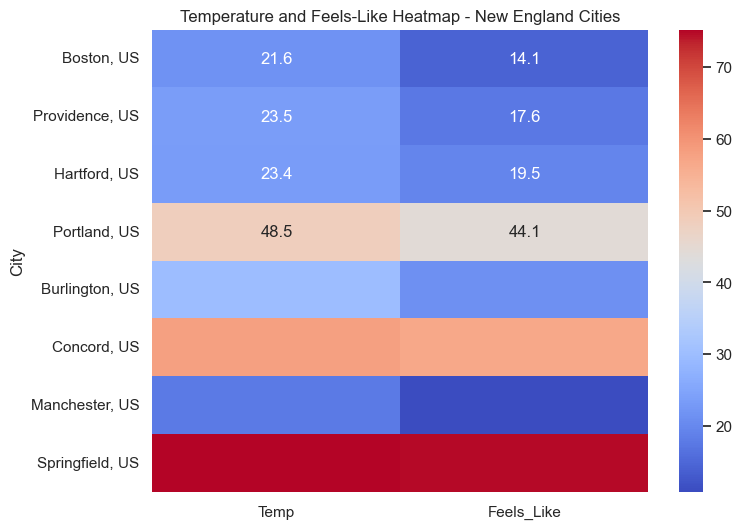

In [117]:
# Pivot DataFrame for heatmap
temp_df = df[['City', 'Temp', 'Feels_Like']].set_index('City')

plt.figure(figsize=(8,6))
sns.heatmap(temp_df, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Temperature and Feels-Like Heatmap - New England Cities")
plt.show()

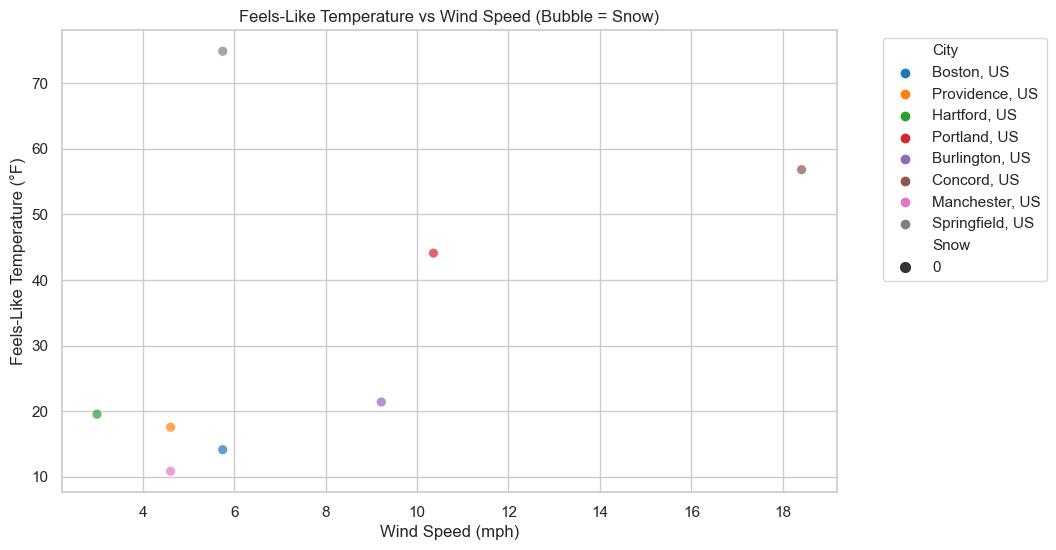

In [118]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='Wind', y='Feels_Like', size='Snow', hue='City', data=df,
    sizes=(50, 500), palette='tab10', alpha=0.7
)
plt.title("Feels-Like Temperature vs Wind Speed (Bubble = Snow)")
plt.xlabel("Wind Speed (mph)")
plt.ylabel("Feels-Like Temperature (°F)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

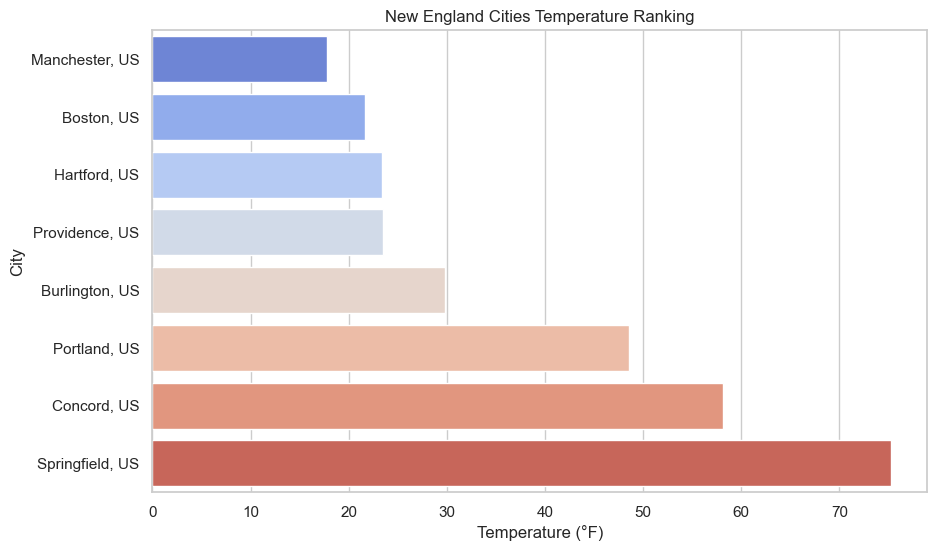

In [119]:
df_sorted = df.sort_values('Temp')

plt.figure(figsize=(10,6))
sns.barplot(x='Temp', y='City', data=df_sorted, palette='coolwarm')
plt.title("New England Cities Temperature Ranking")
plt.xlabel("Temperature (°F)")
plt.ylabel("City")
plt.show()

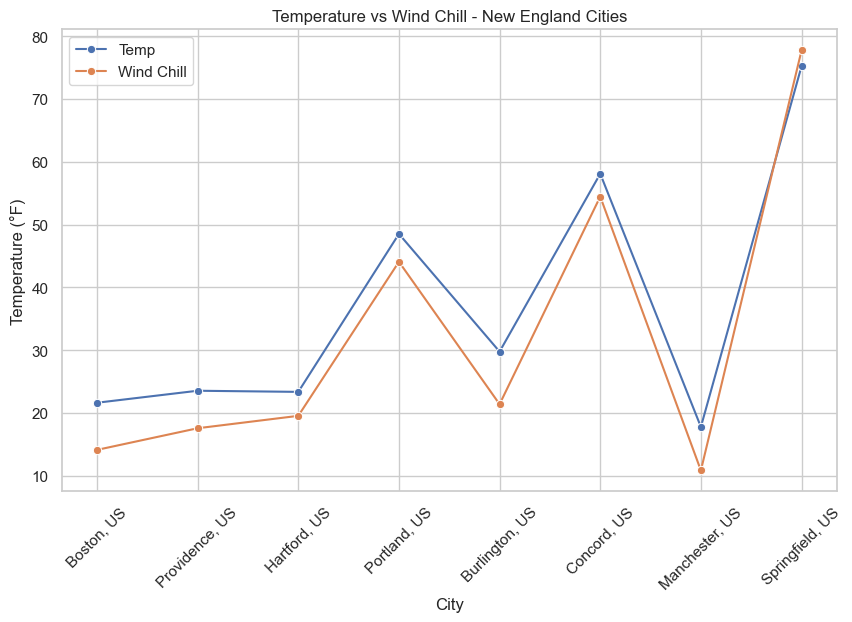

In [120]:
plt.figure(figsize=(10,6))

# Include data=df so seaborn can find column names
sns.lineplot(x='City', y='Temp', marker='o', label='Temp', data=df)
sns.lineplot(x='City', y='Wind_Chill', marker='o', label='Wind Chill', data=df)

plt.title("Temperature vs Wind Chill - New England Cities")
plt.ylabel("Temperature (°F)")
plt.xticks(rotation=45)
plt.legend()
plt.show()